In [1]:
import os
import re
import cv2
import time
import shutil
import zipfile
import urllib.request
import copy
import numpy as np
import random
import scipy
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
import glob
from pandas.core.common import flatten

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
train_data_path = '../input/indian-food-image/dataset'
img_size = (512, 512)

# Генерация train-test выборок

In [4]:
from collections import defaultdict

train_image_paths = defaultdict(list)
classes = []

for data_path in os.listdir(train_data_path):
    cur_class = data_path.split('/')[-1]
    classes.append(cur_class)

    for img_name in os.listdir(train_data_path + "/" + data_path):
        train_image_paths[cur_class].append(train_data_path + "/" + data_path + "/" + img_name)
    
for cls in train_image_paths.keys():
    random.shuffle(train_image_paths[cls])

test_share = 0.2
test_image_paths = defaultdict(list)

for cls in train_image_paths.keys():
    all_samples = train_image_paths[cls]
    train_image_paths[cls] = all_samples[:int(len(all_samples) * (1 - test_share))]
    test_image_paths[cls] = all_samples[int(len(all_samples) * (1 - test_share)):]

train_image_paths = list(flatten(train_image_paths.values()))
test_image_paths = list(flatten(test_image_paths.values()))

random.shuffle(train_image_paths)

train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 


print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Train size: 2560
Valid size: 640
Test size: 800


In [5]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

# Аугментирование датасета

In [6]:
from torch.utils.data import Dataset, DataLoader

class AddGaussianNoise:
    def __init__(self, mean=0., stddev=.1):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)


train_transformation = transforms.Compose([
    transforms.Resize(size=img_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # AddGaussianNoise(),
])

test_transformation = transforms.Compose([
        transforms.Resize(size=img_size),
        transforms.ToTensor(),
    ])

In [7]:
class FoodDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath)
        image = image.convert('RGB')
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            try:
                image = self.transform(image)
            except RuntimeError as e:
                print(image_filepath)
                print(type(image))
        
        return image, label
    

train_dataset = FoodDataset(train_image_paths,train_transformation)
valid_dataset = FoodDataset(valid_image_paths,test_transformation)
test_dataset = FoodDataset(test_image_paths,test_transformation)

In [8]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 512, 512])
The label for 50th image in train dataset:  31


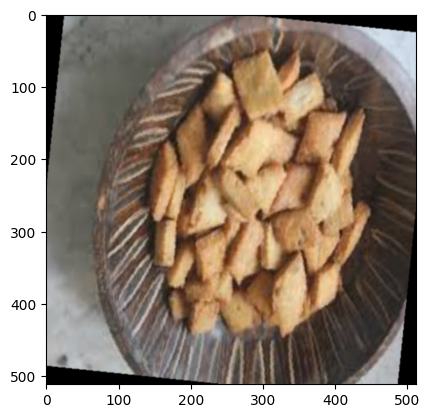

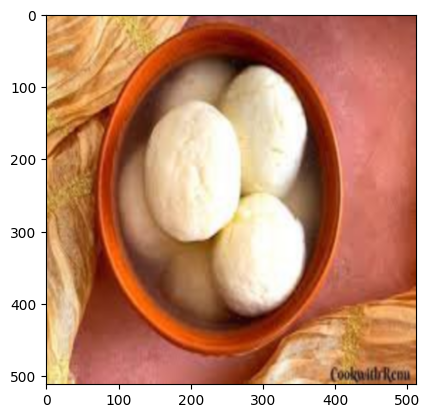

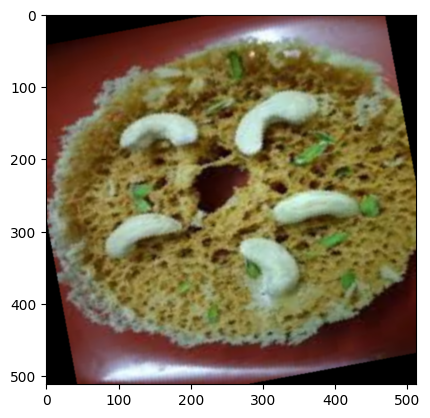

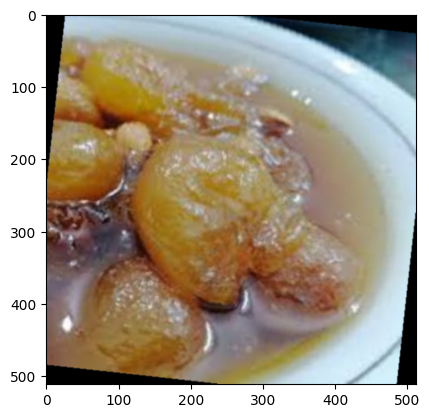

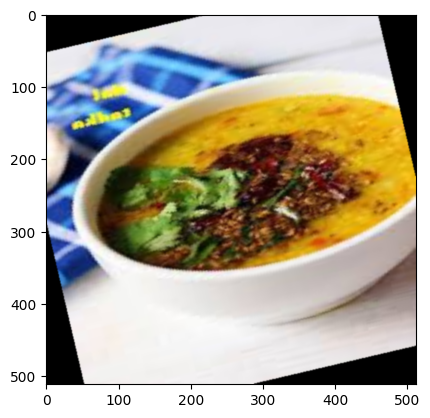

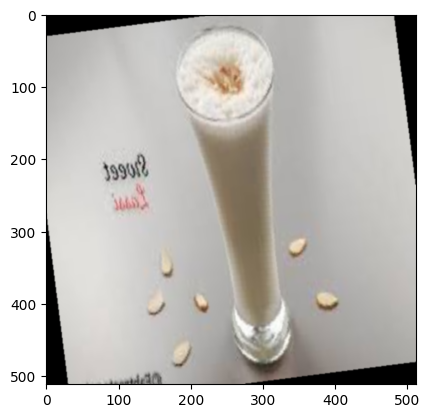

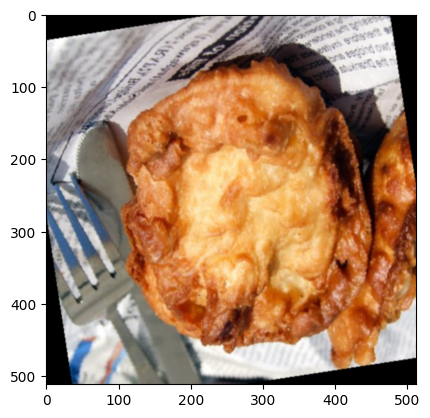

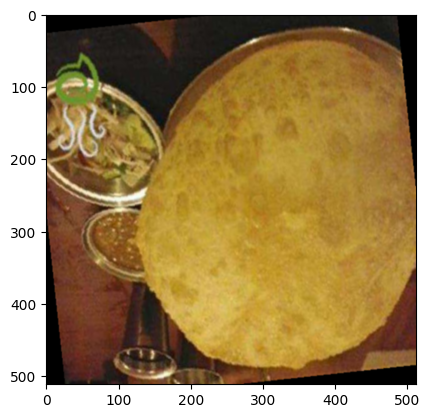

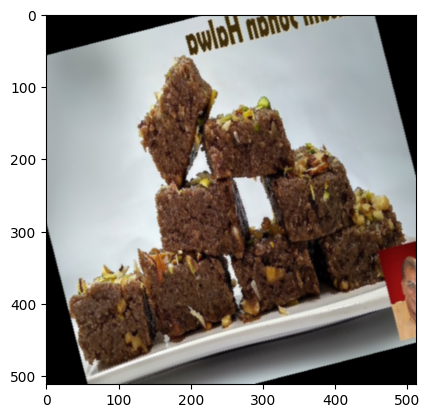

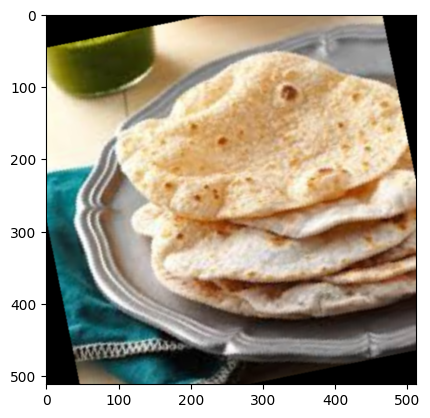

In [9]:
for i in range(10):
    image = train_dataset[i][0]
    
    plt.imshow(transforms.ToPILImage()(image), interpolation="bicubic")
    plt.show()

In [10]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

val_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [26]:
import tqdm
from torchvision.models import mobilenet_v3_large, mobilenet_v3_small, MobileNet_V3_Large_Weights, MobileNet_V3_Small_Weights

model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)

model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(960, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 80)
)

for param in model.features[:-13].parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=960, out_features=256, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=256, out_features=80, bias=True)
)

In [16]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    counter = 1
    correct = 0
    # Process the images in batches
    for data, target in tqdm.tqdm_notebook(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        predicted = torch.argmax(output.data, dim=1)
        
        correct += torch.sum(target.data==predicted)

        # Get the loss
        loss = loss_function(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tLoss: {:.6f}'.format(loss.item()))
        counter += 1
            
    avg_loss = train_loss / counter
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    print(f'Accuracy: {100. * correct / len(train_loader.dataset)}%')
    return avg_loss

In [18]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            test_loss += loss_function(output, target).item()
            

            predicted = torch.argmax(output.data, dim=1)
            correct += torch.sum(target.data==predicted).float()

    avg_loss = test_loss / batch_count
    accuracy = 100. * correct/ len(test_loader.dataset)
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        accuracy))
    
    return avg_loss, accuracy

In [22]:
def train_with_patience(model, device, train_loader, val_loader, optimizer, scheduler, epochs=15):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        train_loss = train(model, device, train_loader, optimizer, epoch)
        val_loss, val_accuracy = test(model, device, val_loader)
        
        # Step the scheduler
        if scheduler:
            scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    return train_losses, val_losses, val_accuracies


# Исходное качество модели

In [21]:
device = "cpu"
if (torch.cuda.is_available()):
    device = "cuda"
    model.cuda()


loss_function = nn.CrossEntropyLoss()
test(model, device, val_loader)

Validation set: Average loss: 4.389537, Accuracy: 7.0/640 (1%)



(4.389536714553833, tensor(1.0938, device='cuda:0'))

# Дообучение модели

In [27]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

loss_function = nn.CrossEntropyLoss()

device = "cpu"
if (torch.cuda.is_available()):
    device = "cuda"
    model.cuda()

print('Training on', device)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
train_losses, val_losses, val_accuracies = train_with_patience(model, device, train_loader, val_loader, optimizer, scheduler, epochs=15)

Training on cuda

Epoch 1/15
Epoch: 1


/tmp/ipykernel_49/4000487722.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data, target in tqdm.tqdm_notebook(train_loader):


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 4.384384
	Loss: 4.396125
	Loss: 4.384725
	Loss: 4.374884
	Loss: 4.343928
	Loss: 4.344337
	Loss: 4.397077
	Loss: 4.313691
	Loss: 4.354722
	Loss: 4.337797
	Loss: 4.234371
	Loss: 4.290021
	Loss: 4.332408
	Loss: 4.332683
	Loss: 4.160333
	Loss: 4.209208
	Loss: 4.194508
	Loss: 4.215060
	Loss: 4.069493
	Loss: 4.264712
	Loss: 4.103068
	Loss: 4.234546
	Loss: 4.047714
	Loss: 4.014063
	Loss: 4.049971
	Loss: 3.899921
	Loss: 3.817042
	Loss: 3.701913
	Loss: 3.826207
	Loss: 3.804685
	Loss: 3.818396
	Loss: 3.588313
	Loss: 3.541751
	Loss: 3.917353
	Loss: 3.705727
	Loss: 3.491507
	Loss: 3.396826
	Loss: 2.968944
	Loss: 3.529982
	Loss: 3.457145
Training set: Average loss: 3.923160
Accuracy: 7.7734375%
Validation set: Average loss: 3.952913, Accuracy: 65.0/640 (10%)

Saved best model

Epoch 2/15
Epoch: 2


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 3.224835
	Loss: 3.093747
	Loss: 2.873982
	Loss: 2.714771
	Loss: 3.119909
	Loss: 2.932238
	Loss: 3.179079
	Loss: 3.036360
	Loss: 2.751579
	Loss: 2.749035
	Loss: 2.740678
	Loss: 2.588254
	Loss: 2.694829
	Loss: 2.694692
	Loss: 2.898607
	Loss: 2.507575
	Loss: 2.490077
	Loss: 2.675802
	Loss: 2.256629
	Loss: 2.500777
	Loss: 2.360259
	Loss: 2.447615
	Loss: 2.498656
	Loss: 2.411452
	Loss: 2.468110
	Loss: 2.414654
	Loss: 2.463391
	Loss: 2.897090
	Loss: 2.679847
	Loss: 2.647140
	Loss: 2.173347
	Loss: 2.491277
	Loss: 2.420345
	Loss: 2.473938
	Loss: 2.327028
	Loss: 2.206252
	Loss: 2.267575
	Loss: 2.427721
	Loss: 2.370098
	Loss: 2.643729
Training set: Average loss: 2.556414
Accuracy: 29.1015625%
Validation set: Average loss: 3.063059, Accuracy: 136.0/640 (21%)

Saved best model

Epoch 3/15
Epoch: 3


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 1.786596
	Loss: 2.148110
	Loss: 2.012383
	Loss: 1.784958
	Loss: 2.108213
	Loss: 1.825486
	Loss: 1.927972
	Loss: 1.969799
	Loss: 2.097966
	Loss: 1.792938
	Loss: 1.932382
	Loss: 1.856873
	Loss: 1.918960
	Loss: 2.141901
	Loss: 1.965479
	Loss: 1.896474
	Loss: 1.616345
	Loss: 1.491344
	Loss: 1.699793
	Loss: 1.619617
	Loss: 2.175456
	Loss: 1.774981
	Loss: 1.917534
	Loss: 1.909346
	Loss: 1.824609
	Loss: 1.666293
	Loss: 1.920007
	Loss: 1.838670
	Loss: 1.802843
	Loss: 1.861196
	Loss: 2.042420
	Loss: 2.142771
	Loss: 1.748258
	Loss: 2.265837
	Loss: 1.869759
	Loss: 1.822978
	Loss: 1.671314
	Loss: 1.845222
	Loss: 1.736793
	Loss: 1.366352
Training set: Average loss: 1.824298
Accuracy: 46.4453125%
Validation set: Average loss: 3.014317, Accuracy: 173.0/640 (27%)

Saved best model

Epoch 4/15
Epoch: 4


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 1.883701
	Loss: 1.577453
	Loss: 1.472085
	Loss: 1.306623
	Loss: 1.485871
	Loss: 1.214292
	Loss: 1.579243
	Loss: 1.986637
	Loss: 1.526974
	Loss: 1.812433
	Loss: 1.120275
	Loss: 1.556703
	Loss: 1.378405
	Loss: 1.410647
	Loss: 1.510482
	Loss: 1.423242
	Loss: 1.277024
	Loss: 1.661348
	Loss: 1.659513
	Loss: 1.621518
	Loss: 1.381199
	Loss: 1.434496
	Loss: 1.583272
	Loss: 1.313841
	Loss: 1.412299
	Loss: 1.308065
	Loss: 1.760843
	Loss: 1.484028
	Loss: 1.504736
	Loss: 1.612248
	Loss: 1.543109
	Loss: 1.277736
	Loss: 1.612233
	Loss: 1.420359
	Loss: 1.655584
	Loss: 1.656124
	Loss: 1.273261
	Loss: 1.466951
	Loss: 1.498709
	Loss: 1.214084
Training set: Average loss: 1.460430
Accuracy: 56.328125%
Validation set: Average loss: 4.769048, Accuracy: 150.0/640 (23%)


Epoch 5/15
Epoch: 5


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 1.152108
	Loss: 1.100263
	Loss: 1.130386
	Loss: 1.037486
	Loss: 1.512037
	Loss: 1.152972
	Loss: 1.135102
	Loss: 1.454414
	Loss: 1.462668
	Loss: 1.582211
	Loss: 1.082255
	Loss: 1.195758
	Loss: 1.132049
	Loss: 1.095131
	Loss: 1.398081
	Loss: 1.415828
	Loss: 1.420005
	Loss: 1.370079
	Loss: 0.997238
	Loss: 1.300096
	Loss: 1.093212
	Loss: 1.375345
	Loss: 1.076182
	Loss: 1.033303
	Loss: 0.985377
	Loss: 1.250473
	Loss: 1.489042
	Loss: 1.034726
	Loss: 1.133749
	Loss: 1.317694
	Loss: 0.993741
	Loss: 0.956064
	Loss: 1.223368
	Loss: 1.010394
	Loss: 1.276862
	Loss: 1.152965
	Loss: 1.031786
	Loss: 1.305132
	Loss: 1.137022
	Loss: 1.177576
Training set: Average loss: 1.175126
Accuracy: 62.8125%
Validation set: Average loss: 3.204664, Accuracy: 231.0/640 (36%)


Epoch 6/15
Epoch: 6


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 1.095657
	Loss: 0.954308
	Loss: 1.019150
	Loss: 0.943899
	Loss: 0.860046
	Loss: 0.784514
	Loss: 1.059941
	Loss: 0.961819
	Loss: 0.881898
	Loss: 0.955972
	Loss: 1.035006
	Loss: 0.918191
	Loss: 0.702302
	Loss: 1.170535
	Loss: 1.213431
	Loss: 1.113626
	Loss: 1.029544
	Loss: 0.908737
	Loss: 1.007946
	Loss: 0.921849
	Loss: 1.018163
	Loss: 1.073714
	Loss: 0.847786
	Loss: 0.917780
	Loss: 1.231491
	Loss: 1.268396
	Loss: 0.965871
	Loss: 0.846108
	Loss: 1.215676
	Loss: 1.076219
	Loss: 1.184490
	Loss: 0.796488
	Loss: 1.026212
	Loss: 1.432811
	Loss: 1.158805
	Loss: 1.094577
	Loss: 1.583608
	Loss: 0.929967
	Loss: 1.241090
	Loss: 0.786219
Training set: Average loss: 1.005703
Accuracy: 67.421875%
Validation set: Average loss: 2.687838, Accuracy: 252.0/640 (39%)

Saved best model

Epoch 7/15
Epoch: 7


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 0.844358
	Loss: 0.891861
	Loss: 0.843480
	Loss: 0.917537
	Loss: 0.704087
	Loss: 0.738015
	Loss: 0.971116
	Loss: 0.903406
	Loss: 0.735137
	Loss: 0.707712
	Loss: 0.687697
	Loss: 0.832120
	Loss: 0.810249
	Loss: 1.119233
	Loss: 0.871523
	Loss: 0.737232
	Loss: 0.753379
	Loss: 0.663602
	Loss: 0.868181
	Loss: 1.108837
	Loss: 0.872793
	Loss: 0.902515
	Loss: 0.866836
	Loss: 0.752812
	Loss: 0.965863
	Loss: 1.043079
	Loss: 0.759019
	Loss: 0.540387
	Loss: 0.938533
	Loss: 1.248789
	Loss: 0.715121
	Loss: 0.756194
	Loss: 0.794362
	Loss: 0.943194
	Loss: 0.900618
	Loss: 0.739354
	Loss: 0.790654
	Loss: 0.891416
	Loss: 0.807142
	Loss: 1.044783
Training set: Average loss: 0.828835
Accuracy: 72.890625%
Validation set: Average loss: 2.749377, Accuracy: 265.0/640 (41%)


Epoch 8/15
Epoch: 8


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 0.739521
	Loss: 0.509907
	Loss: 0.604051
	Loss: 0.598146
	Loss: 0.633988
	Loss: 0.894586
	Loss: 0.594312
	Loss: 0.635799
	Loss: 0.554449
	Loss: 0.686869
	Loss: 0.571903
	Loss: 0.538840
	Loss: 0.827358
	Loss: 0.698617
	Loss: 0.586645
	Loss: 0.471153
	Loss: 0.620528
	Loss: 0.659013
	Loss: 0.674388
	Loss: 0.730444
	Loss: 0.908012
	Loss: 1.020575
	Loss: 0.510574
	Loss: 0.701773
	Loss: 0.614781
	Loss: 0.731488
	Loss: 0.660952
	Loss: 0.947008
	Loss: 0.948914
	Loss: 0.923937
	Loss: 0.649303
	Loss: 0.970182
	Loss: 0.812678
	Loss: 0.804481
	Loss: 0.782291
	Loss: 0.604485
	Loss: 0.955839
	Loss: 0.765480
	Loss: 0.717152
	Loss: 0.778741
Training set: Average loss: 0.698516
Accuracy: 77.8515625%
Validation set: Average loss: 3.003000, Accuracy: 261.0/640 (41%)


Epoch 9/15
Epoch: 9


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 0.742325
	Loss: 0.470929
	Loss: 0.619904
	Loss: 0.580599
	Loss: 0.517582
	Loss: 0.469470
	Loss: 0.485317
	Loss: 0.438357
	Loss: 0.707057
	Loss: 0.595500
	Loss: 0.585213
	Loss: 0.632038
	Loss: 0.731430
	Loss: 0.474307
	Loss: 0.833956
	Loss: 0.959131
	Loss: 0.548314
	Loss: 0.566736
	Loss: 0.560140
	Loss: 0.810060
	Loss: 0.563171
	Loss: 0.512823
	Loss: 0.578513
	Loss: 0.697140
	Loss: 0.750289
	Loss: 0.741022
	Loss: 0.791858
	Loss: 0.560572
	Loss: 0.437904
	Loss: 0.626529
	Loss: 0.801528
	Loss: 0.741918
	Loss: 0.906093
	Loss: 1.031695
	Loss: 0.799244
	Loss: 0.859881
	Loss: 0.823972
	Loss: 0.683787
	Loss: 0.555090
	Loss: 0.825347
Training set: Average loss: 0.649189
Accuracy: 78.0859375%
Validation set: Average loss: 2.277867, Accuracy: 300.0/640 (47%)

Saved best model

Epoch 10/15
Epoch: 10


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 0.371914
	Loss: 0.657902
	Loss: 0.585613
	Loss: 0.554291
	Loss: 0.387833
	Loss: 0.404716
	Loss: 0.464772
	Loss: 0.911618
	Loss: 0.432408
	Loss: 0.504366
	Loss: 0.398061
	Loss: 0.429570
	Loss: 0.669141
	Loss: 0.527768
	Loss: 0.441970
	Loss: 0.435992
	Loss: 0.426498
	Loss: 0.784635
	Loss: 0.360507
	Loss: 0.355524
	Loss: 0.697921
	Loss: 0.728819
	Loss: 0.428091
	Loss: 0.644543
	Loss: 0.435867
	Loss: 0.556064
	Loss: 0.501971
	Loss: 0.632553
	Loss: 0.474272
	Loss: 0.518535
	Loss: 0.412336
	Loss: 0.403061
	Loss: 0.502255
	Loss: 0.439920
	Loss: 0.570154
	Loss: 0.766672
	Loss: 0.678360
	Loss: 0.414343
	Loss: 0.436758
	Loss: 0.451276
Training set: Average loss: 0.507290
Accuracy: 83.4375%
Validation set: Average loss: 2.468687, Accuracy: 296.0/640 (46%)


Epoch 11/15
Epoch: 11


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 0.499676
	Loss: 0.373141
	Loss: 0.423951
	Loss: 0.530970
	Loss: 0.492005
	Loss: 0.393591
	Loss: 0.489110
	Loss: 0.344439
	Loss: 0.406400
	Loss: 0.606887
	Loss: 0.508813
	Loss: 0.343085
	Loss: 0.498099
	Loss: 0.460650
	Loss: 0.456336
	Loss: 0.423744
	Loss: 0.423061
	Loss: 0.377194
	Loss: 0.621418
	Loss: 0.357488
	Loss: 0.375351
	Loss: 0.392446
	Loss: 0.564285
	Loss: 0.298457
	Loss: 0.768760
	Loss: 0.432188
	Loss: 0.493339
	Loss: 0.355658
	Loss: 0.450782
	Loss: 0.348753
	Loss: 0.260658
	Loss: 0.521922
	Loss: 0.526925
	Loss: 0.345720
	Loss: 0.558382
	Loss: 0.584240
	Loss: 0.424925
	Loss: 0.366230
	Loss: 0.384175
	Loss: 0.395898
Training set: Average loss: 0.436077
Accuracy: 86.25%
Validation set: Average loss: 2.152770, Accuracy: 358.0/640 (56%)

Saved best model

Epoch 12/15
Epoch: 12


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 0.338657
	Loss: 0.314012
	Loss: 0.299038
	Loss: 0.344176
	Loss: 0.481029
	Loss: 0.329944
	Loss: 0.274658
	Loss: 0.320543
	Loss: 0.312872
	Loss: 0.352141
	Loss: 0.306767
	Loss: 0.286367
	Loss: 0.422998
	Loss: 0.404545
	Loss: 0.229844
	Loss: 0.319028
	Loss: 0.452942
	Loss: 0.460515
	Loss: 0.493361
	Loss: 0.291045
	Loss: 0.638598
	Loss: 0.624395
	Loss: 0.339489
	Loss: 0.366287
	Loss: 0.565524
	Loss: 0.587644
	Loss: 0.687046
	Loss: 0.469920
	Loss: 0.452660
	Loss: 0.549467
	Loss: 0.374543
	Loss: 0.660152
	Loss: 0.260001
	Loss: 0.251033
	Loss: 0.264955
	Loss: 0.629509
	Loss: 0.667338
	Loss: 0.813340
	Loss: 0.500968
	Loss: 0.327704
Training set: Average loss: 0.416221
Accuracy: 86.953125%
Validation set: Average loss: 2.269154, Accuracy: 324.0/640 (51%)


Epoch 13/15
Epoch: 13


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 0.364533
	Loss: 0.241089
	Loss: 0.363121
	Loss: 0.454235
	Loss: 0.356200
	Loss: 0.331184
	Loss: 0.574953
	Loss: 0.396503
	Loss: 0.495391
	Loss: 0.362316
	Loss: 0.280742
	Loss: 0.288347
	Loss: 0.328708
	Loss: 0.398439
	Loss: 0.548238
	Loss: 0.606728
	Loss: 0.341563
	Loss: 0.372796
	Loss: 0.442488
	Loss: 0.191993
	Loss: 0.219727
	Loss: 0.267743
	Loss: 0.512198
	Loss: 0.496403
	Loss: 0.296275
	Loss: 0.500280
	Loss: 0.385807
	Loss: 0.355308
	Loss: 0.316807
	Loss: 0.268446
	Loss: 0.275192
	Loss: 0.297132
	Loss: 0.342422
	Loss: 0.213162
	Loss: 0.459703
	Loss: 0.544328
	Loss: 0.405452
	Loss: 0.426892
	Loss: 0.375989
	Loss: 0.383350
Training set: Average loss: 0.367858
Accuracy: 87.578125%
Validation set: Average loss: 2.325834, Accuracy: 339.0/640 (53%)


Epoch 14/15
Epoch: 14


  0%|          | 0/40 [00:00<?, ?it/s]

	Loss: 0.303771
	Loss: 0.232909
	Loss: 0.410702
	Loss: 0.306949
	Loss: 0.234851
	Loss: 0.295289
	Loss: 0.254635
	Loss: 0.297518
	Loss: 0.294840
	Loss: 0.449026
	Loss: 0.406351
	Loss: 0.318965
	Loss: 0.174143
	Loss: 0.365621
	Loss: 0.263870
	Loss: 0.121868
	Loss: 0.641915
	Loss: 0.470256
	Loss: 0.336164
	Loss: 0.467753
	Loss: 0.165070
	Loss: 0.375338
	Loss: 0.242369
	Loss: 0.320113
	Loss: 0.260625
	Loss: 0.343913
	Loss: 0.351731
	Loss: 0.541030
	Loss: 0.475603
	Loss: 0.510763
	Loss: 0.334641
	Loss: 0.370010
	Loss: 0.520682
	Loss: 0.450364
	Loss: 0.354630
	Loss: 0.233846
	Loss: 0.317464
	Loss: 0.506365
	Loss: 0.203313
	Loss: 0.190535
Training set: Average loss: 0.334532
Accuracy: 89.53125%
Validation set: Average loss: 2.291504, Accuracy: 357.0/640 (56%)

Early stopping at epoch 14


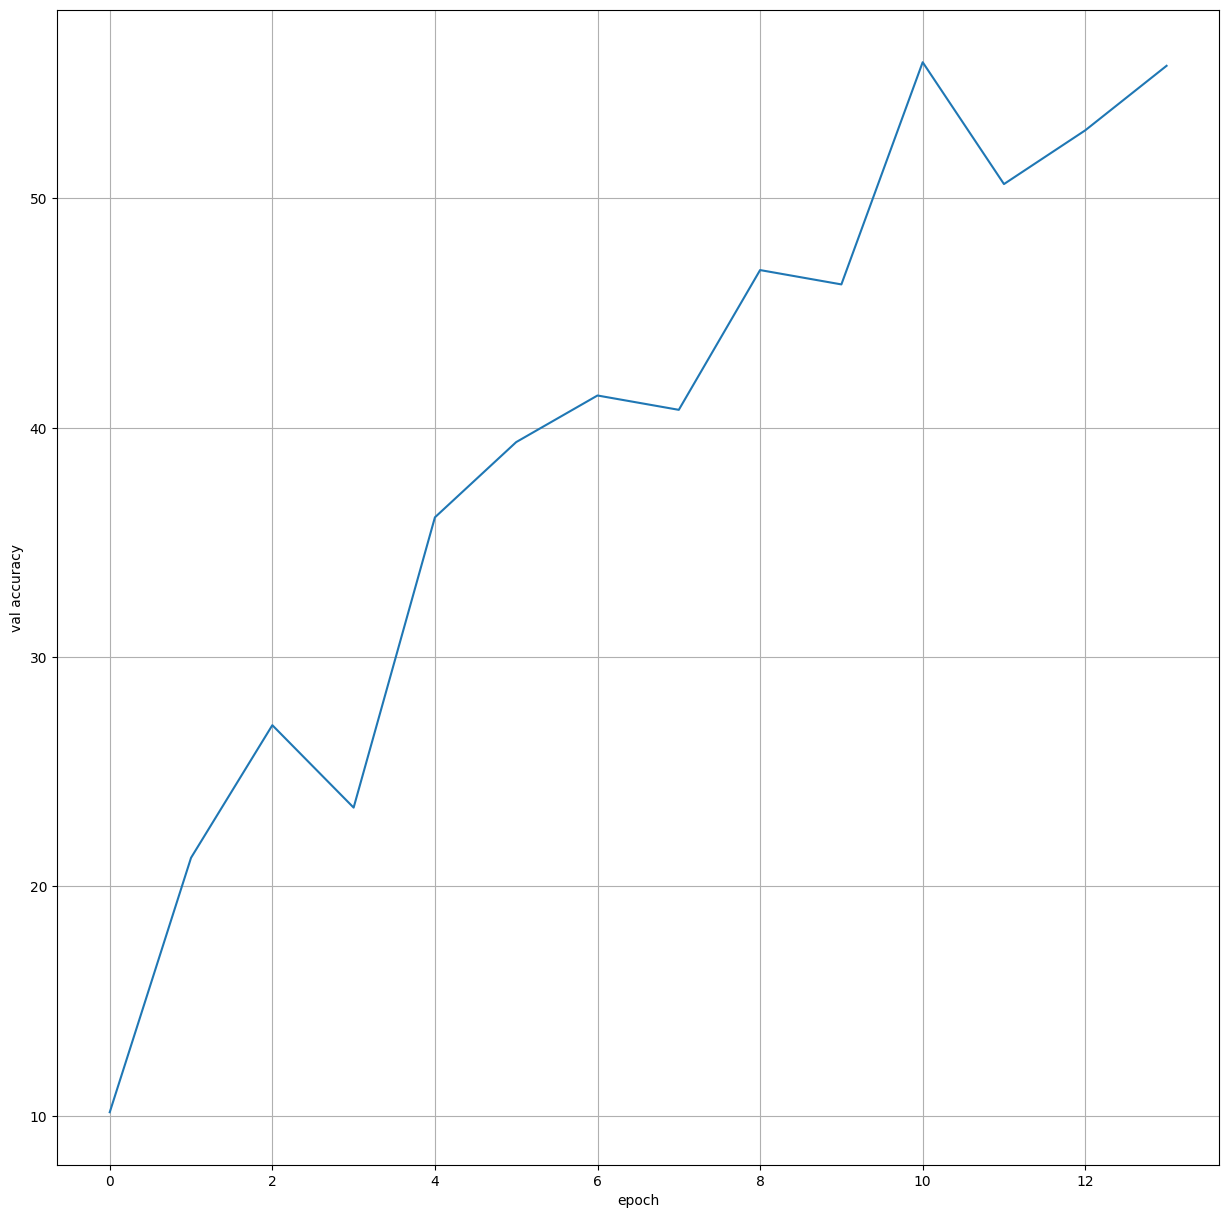

In [37]:
plt.figure(figsize=(15,15))
plt.plot([acc.cpu().float() for acc in val_accuracies])
plt.xlabel('epoch')
plt.ylabel('val accuracy')
plt.grid()
plt.show()

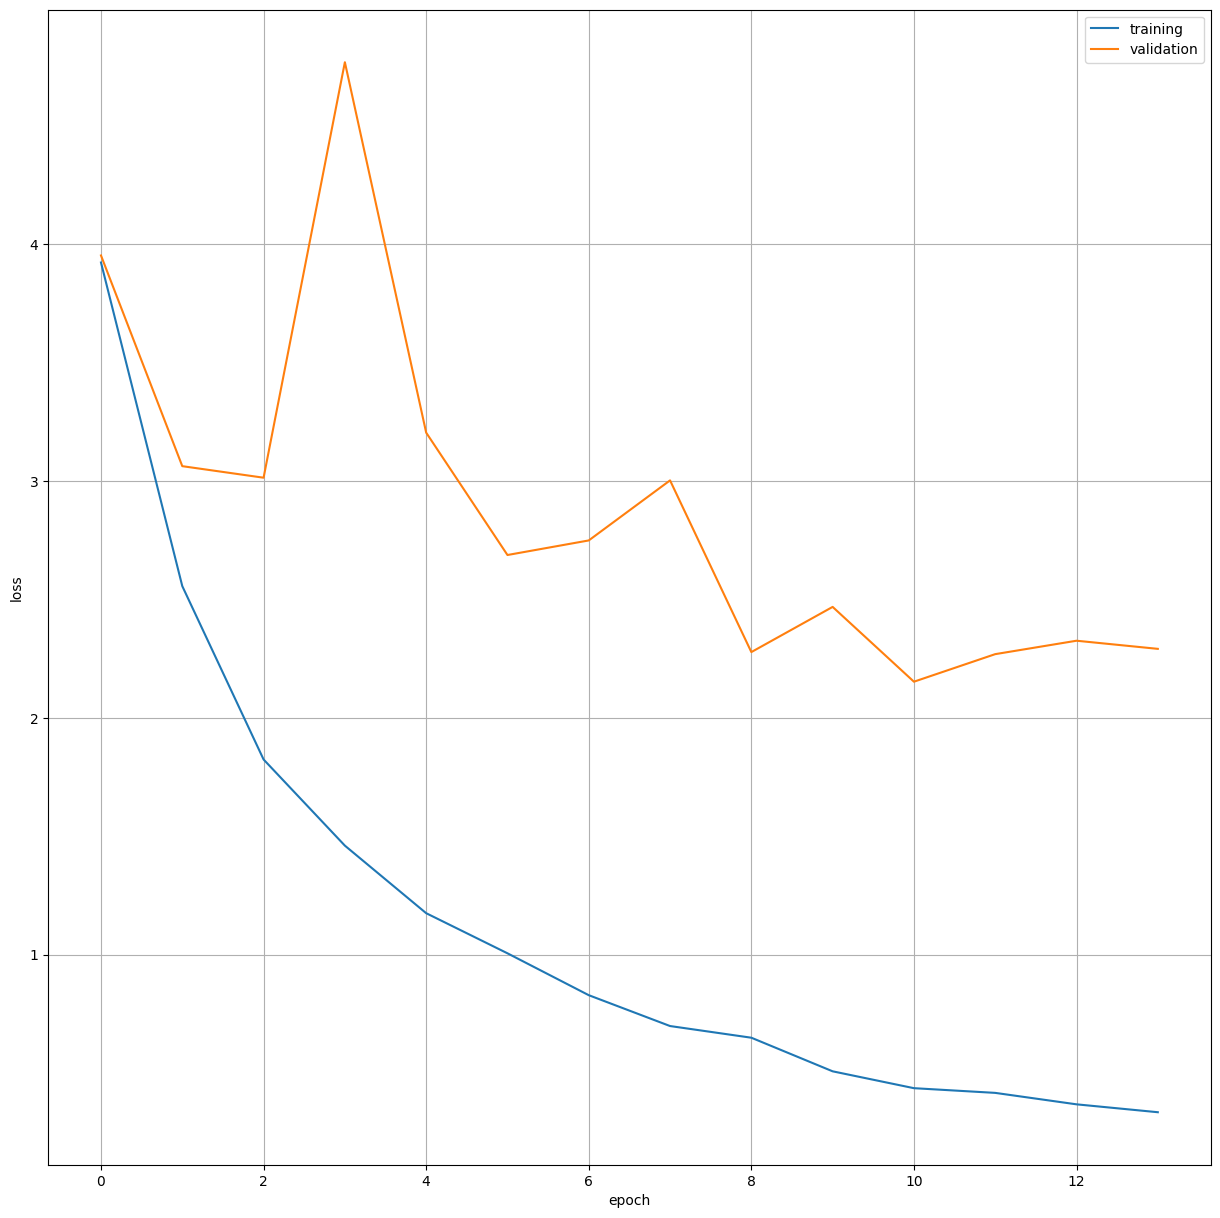

In [32]:
plt.figure(figsize=(15,15))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns


truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        output = output.cpu()
        predicted = torch.argmax(output.data, dim=1)
        data = data.cpu()
        target = target.cpu()
        
        for label in target.data.numpy():
            truelabels.append(label)
        for prediction in predicted:
            predictions.append(prediction) 

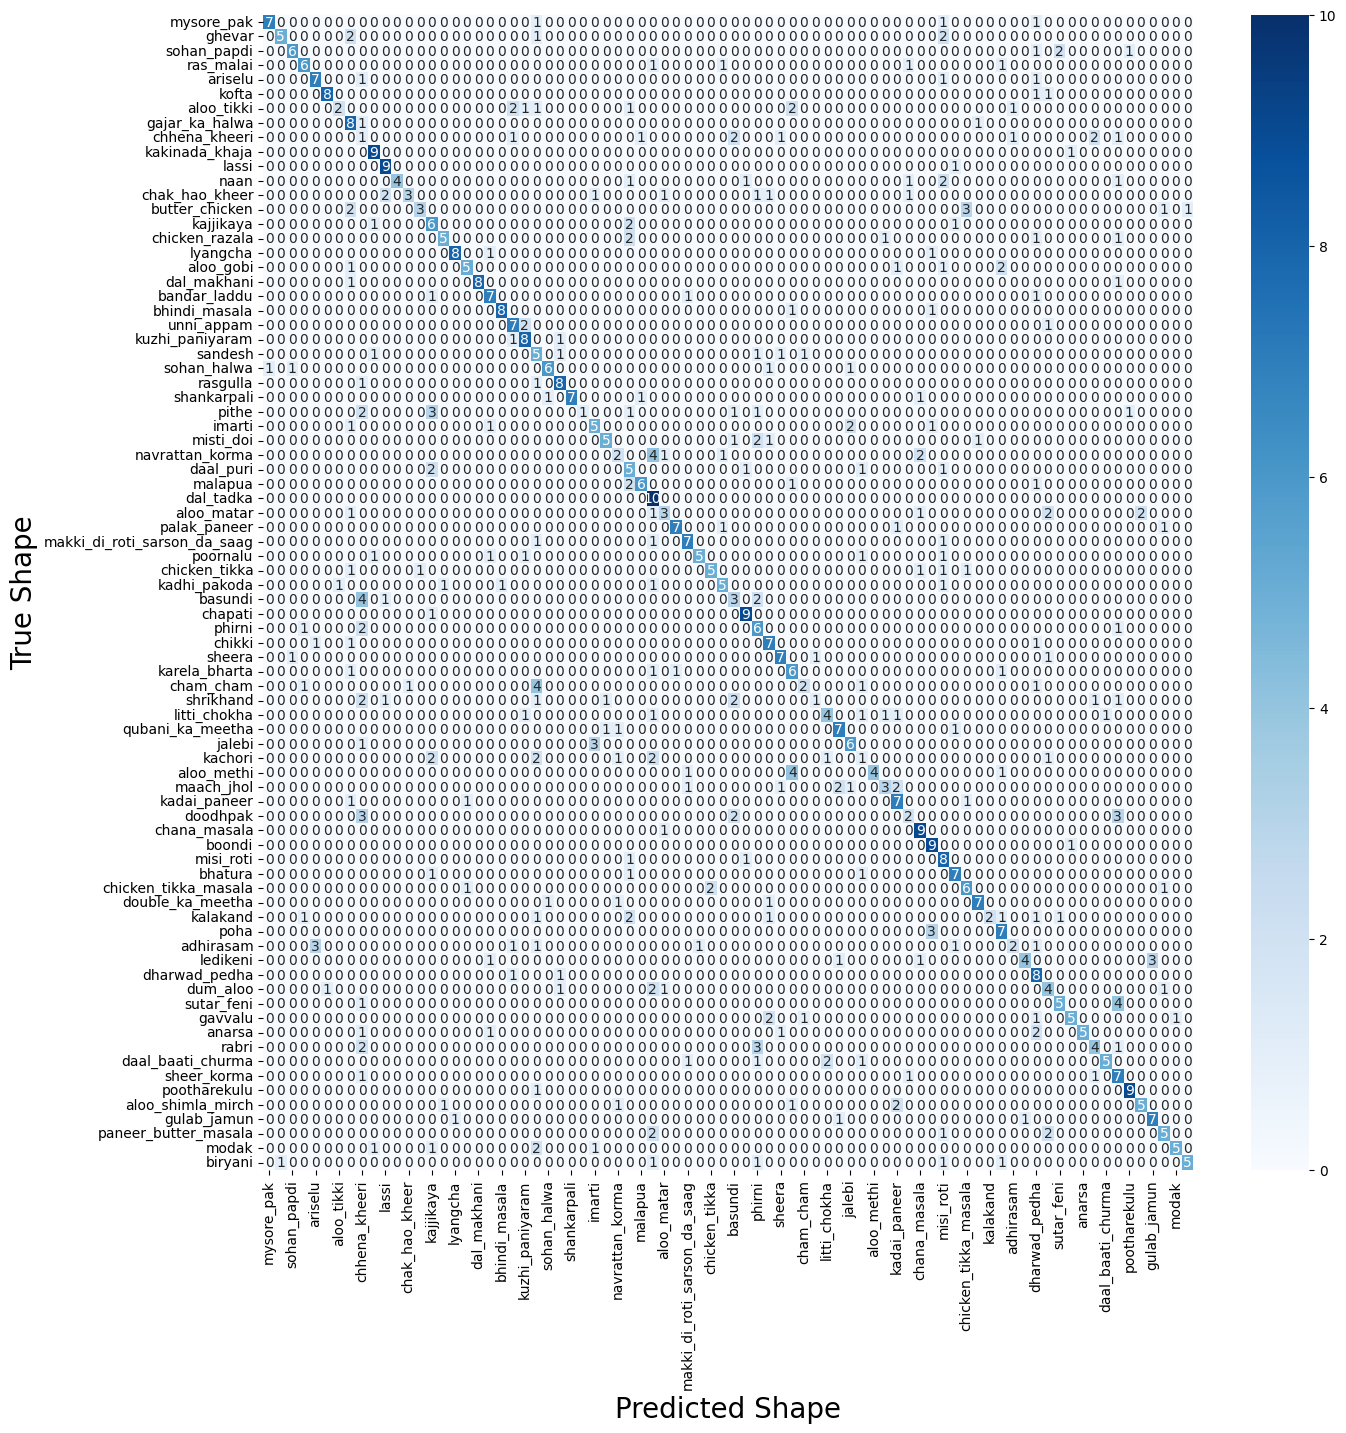

In [42]:
# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (15,15))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

In [44]:
test(model, device, test_loader)

Validation set: Average loss: 2.201817, Accuracy: 447.0/800 (56%)



(2.201817219073956, tensor(55.8750, device='cuda:0'))

In [39]:
torch.save(model.state_dict(), 'model_params')